In [17]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np

import sys
sys.path.append("..")
from models import CompositeClassifier

In [2]:
x_train = np.load("X-1647041985-early-fusion-vectors-train.arr")
y_train = np.load("y-1647041985-train.arr")

x_test = np.load("X-1647097165-early-fusion-vectors-test.arr")
y_test = np.load("y-1647097165-test.arr")

In [47]:
np.sum(y_test == 1)

13190

In [49]:
len(x_test)

18172

## Different late fusion networks

In [40]:
def fit(models, x_trains, y_train, save=False):
    for model in models:
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_late_fusion_model()

def evaluate(models, x_tests, y_test, ax=None, print_score=True):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(x_tests[model])[:,1]
        preds = np.where(probs[model] > 0.5, 1, 0)
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y_test, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y_test, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y_test.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y_test))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = roc_curve(y_test, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    _ = ax.legend()
    return probs

In [4]:
models = {}
modules = ["malconv", "ember", "filepaths", "emulation"]

repo_root = "../"
params = {
"malconv_model_path": repo_root+'modules/sota/malconv/parameters/malconv.checkpoint',
"ember_2019_model_path": repo_root+'modules/sota/ember/parameters/ember_model.txt',
"filepath_model_path": repo_root+'modules/filepath/pretrained/1646930331-model.torch',
"filepath_bytes": repo_root+'modules/filepath/pretrained/keep_bytes-ed64-pl150-kb150-1646917941.pickle',
"emulation_model_path": repo_root+'modules/emulation/pretrained/1646990611-model.torch',
"emulation_apicalls": repo_root+'modules/emulation/pretrained/api_calls_preserved-ed96-pl150-kb600-1646926097.pickle',
}

models["Logistic Regression"] = CompositeClassifier(modules=modules, late_fusion_model="LogisticRegression", **params)
models["XGBClassifier"] = CompositeClassifier(modules=modules, late_fusion_model="XGBClassifier",**params)
models["MultiLayerPerceptron"] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron",**params)

x_trains = dict([(model, x_train) for model in models])
x_tests = dict([(model, x_test) for model in models])


 ====== Logistic Regression ======
ROC AUC score: 0.9987736442550271
Classification report:
              precision    recall  f1-score   support

         0.0     0.9718    0.9625    0.9671      4982
         1.0     0.9859    0.9895    0.9877     13190

    accuracy                         0.9821     18172
   macro avg     0.9789    0.9760    0.9774     18172
weighted avg     0.9820    0.9821    0.9820     18172


 ====== XGBClassifier ======
ROC AUC score: 0.9990002218753243
Classification report:
              precision    recall  f1-score   support

         0.0     0.9755    0.9659    0.9707      4982
         1.0     0.9872    0.9908    0.9890     13190

    accuracy                         0.9840     18172
   macro avg     0.9813    0.9784    0.9798     18172
weighted avg     0.9840    0.9840    0.9840     18172


 ====== MultiLayerPerceptron ======
ROC AUC score: 0.9988609943484185
Classification report:
              precision    recall  f1-score   support

         0.0     

{'Logistic Regression': array([0.99997299, 0.99997288, 0.99997274, ..., 0.99997119, 0.99989852,
        0.99995451]),
 'XGBClassifier': array([0.9999989 , 0.9999988 , 0.9999988 , ..., 0.9999988 , 0.99999857,
        0.99999595], dtype=float32),
 'MultiLayerPerceptron': array([0.99999675, 0.99999511, 0.9999971 , ..., 0.99999685, 0.9999903 ,
        0.99999445]),
 'No Skill': array([1, 1, 1, ..., 1, 1, 1])}

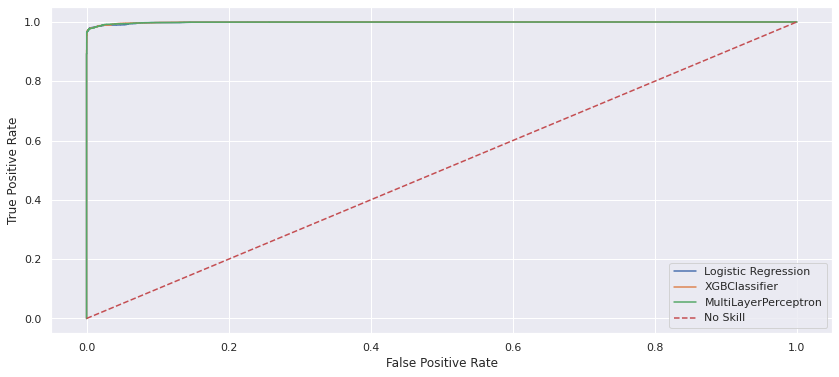

In [5]:
fit(models, x_trains, y_train)
evaluate(models, x_tests, y_test)

## Different modules

In [19]:
modulelist = [["malconv"], ["ember"], ["filepaths"], ["emulation"], 
            ["malconv", "ember", "filepaths", "emulation"], 
            ["malconv", "ember", "emulation"]]
models = {}
x_trains = {}
x_tests = {}
for modules in modulelist:
    name = "_".join(modules)
    if len(modules) == 4:
        name = "All"
    if name == "malconv_ember_emulation":
        name = "PE modules (MalConv, Ember, emulation)"
    
    repo_root = "../"
    params = {
    "malconv_model_path": repo_root+'modules/sota/malconv/parameters/malconv.checkpoint',
    "ember_2019_model_path": repo_root+'modules/sota/ember/parameters/ember_model.txt',
    "filepath_model_path": repo_root+'modules/filepath/pretrained/1646930331-model.torch',
    "filepath_bytes": repo_root+'modules/filepath/pretrained/keep_bytes-ed64-pl150-kb150-1646917941.pickle',
    "emulation_model_path": repo_root+'modules/emulation/pretrained/1646990611-model.torch',
    "emulation_apicalls": repo_root+'modules/emulation/pretrained/api_calls_preserved-ed96-pl150-kb600-1646926097.pickle',
    }
    models[name] = CompositeClassifier(modules=modules, late_fusion_model="MultiLayerPerceptron", **params)
    x_trains[name] = models[name].get_cropped_x(modules, x_train)
    x_tests[name] = models[name].get_cropped_x(modules, x_test)


 ====== malconv ======
ROC AUC score: 0.6906800341730609
Classification report:
              precision    recall  f1-score   support

         0.0     0.7271    0.2481    0.3699      4982
         1.0     0.7726    0.9648    0.8581     13190

    accuracy                         0.7683     18172
   macro avg     0.7498    0.6065    0.6140     18172
weighted avg     0.7601    0.7683    0.7242     18172


 ====== ember ======
ROC AUC score: 0.9860326135421863
Classification report:
              precision    recall  f1-score   support

         0.0     0.8926    0.9773    0.9330      4982
         1.0     0.9911    0.9556    0.9730     13190

    accuracy                         0.9615     18172
   macro avg     0.9418    0.9664    0.9530     18172
weighted avg     0.9641    0.9615    0.9621     18172


 ====== filepaths ======
ROC AUC score: 0.9885937365417702
Classification report:
              precision    recall  f1-score   support

         0.0     0.9516    0.9271    0.9392     

{'malconv': array([0.7784457 , 0.70876362, 0.82267138, ..., 0.80792747, 0.78104391,
        0.79480636]),
 'ember': array([0.99431071, 0.99431027, 0.99431072, ..., 0.99431073, 0.99392332,
        0.98988994]),
 'filepaths': array([0.99885353, 0.99884806, 0.99885198, ..., 0.99879774, 0.9988403 ,
        0.99885158]),
 'emulation': array([0.99482045, 0.99485231, 0.99472134, ..., 0.99450192, 0.95997017,
        0.99494596]),
 'All': array([0.99999855, 0.99999765, 0.99999873, ..., 0.9999986 , 0.99999264,
        0.99999769]),
 'PE modules (MalConv, Ember, emulation)': array([0.99999386, 0.99999378, 0.99999403, ..., 0.99999298, 0.99827779,
        0.99999479]),
 'No Skill': array([1, 1, 1, ..., 1, 1, 1])}

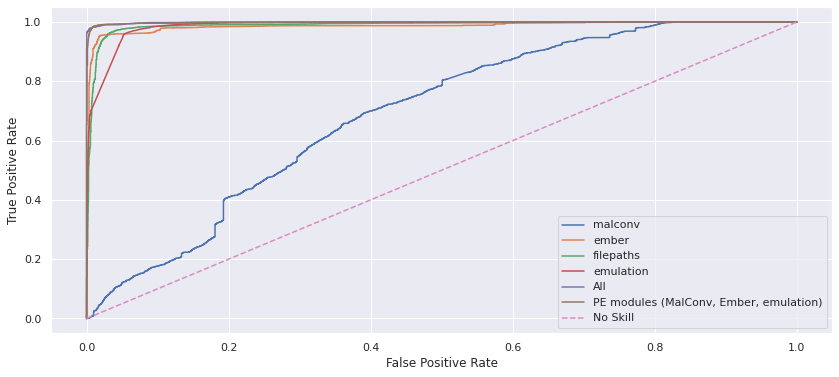

In [21]:
fit(models, x_trains, y_train)
evaluate(models, x_tests, y_test)

In [33]:
models

{'malconv': <models.CompositeClassifier at 0x7f3858b96f28>,
 'ember': <models.CompositeClassifier at 0x7f390d263128>,
 'filepaths': <models.CompositeClassifier at 0x7f39d553fc50>,
 'emulation': <models.CompositeClassifier at 0x7f388190bd68>,
 'All': <models.CompositeClassifier at 0x7f38810afda0>,
 'PE modules (MalConv, Ember, emulation)': <models.CompositeClassifier at 0x7f385bb733c8>}

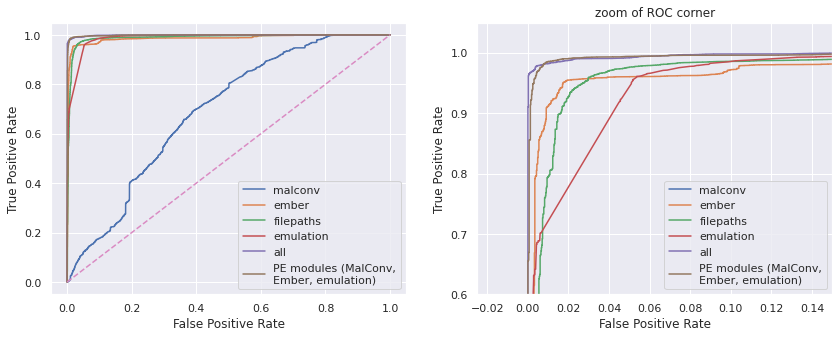

In [44]:
legend = ['malconv', 'ember', 'filepaths', 'emulation', 'all', 'PE modules (MalConv,\nEmber, emulation)']
fig, ax = plt.subplots(1,2, figsize=(14,5))
evaluate(models, x_tests, y_test, ax=ax[0], print_score=False)
probs = evaluate(models, x_tests, y_test, ax=ax[1], print_score=False)
ax[1].set_ylim([0.6, 1.05])
ax[1].set_xlim([-0.025, 0.15])
ax[1].set_title("zoom of ROC corner")
ax[1].legend(legend)
_ = ax[0].legend(legend)

In [13]:
def draw_confusion_matrix(y_true, y_pred, counts=False, figsize=(6,6)):
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    groups = ["True Negative","False Positive","False Negative","True Positive"]

    if counts:
        labels = [f"{y}\n{x}\n{z}" for x,y,z in zip(group_percentages, groups, group_counts)]
    else:
        labels = [f"{y}\n{x}" for x,y in zip(group_percentages, groups)]
    labels = np.asarray(labels).reshape(2,2)

    f, ax = plt.subplots(1,1, figsize=figsize)
    ax = sns.heatmap(cf_matrix, annot=labels, ax=ax,
                fmt='', cbar=False, cmap='Blues',
                xticklabels=["benign", "malicious"],
                yticklabels=["benign", "malicious"])
    ax.set_ylabel("Ground truth label")
    ax.set_xlabel("Prediction")

def print_scores(y_true, y_pred):
    print("F1: ",f1_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("Accuracy: ", (y_true == y_pred).mean() * 100)

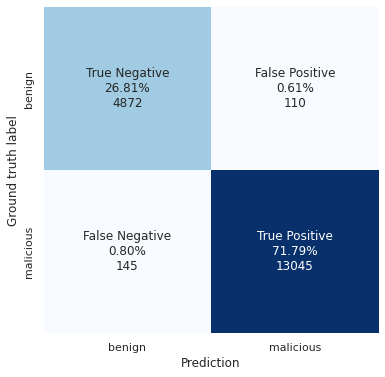

In [14]:
y_pred = (probs["All"] >= 0.5).astype(int)
draw_confusion_matrix(y_test, y_pred, counts=True)

In [15]:
print_scores(y_test, y_pred)

F1:  0.9903207439741887
Recall:  0.9890068233510235
Precision:  0.991638160395287
Accuracy:  98.59674224081004



 ====== malconv ======
ROC AUC score: 0.6933934572431117
Classification report:
              precision    recall  f1-score   support

         0.0     0.8111    0.2245    0.3516     20309
         1.0     0.7651    0.9797    0.8592     52375

    accuracy                         0.7687     72684
   macro avg     0.7881    0.6021    0.6054     72684
weighted avg     0.7780    0.7687    0.7174     72684


 ====== ember ======
ROC AUC score: 0.9864089055594643
Classification report:
              precision    recall  f1-score   support

         0.0     0.8925    0.9738    0.9314     20309
         1.0     0.9895    0.9545    0.9717     52375

    accuracy                         0.9599     72684
   macro avg     0.9410    0.9641    0.9515     72684
weighted avg     0.9624    0.9599    0.9604     72684


 ====== filepaths ======
ROC AUC score: 0.9999358888466745
Classification report:
              precision    recall  f1-score   support

         0.0     0.9960    0.9923    0.9942     

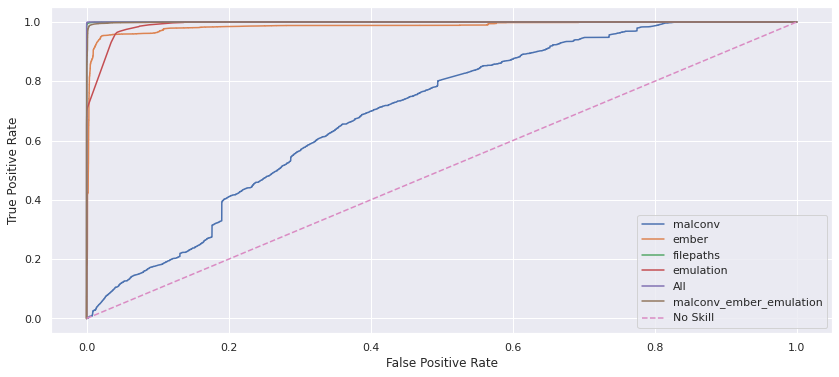

In [16]:
probs = evaluate(models, x_trains, y_train)
y_pred = (probs["All"] >= 0.5).astype(int)
print_scores(y_train, y_pred)
